# Spatial Lambda Fleming Viot process

Класс модели:
    - Аттрибуты:
        - Параметры модели
        - Вложенные классы:
            - Класс состояния:
                - Время
                - Список особей с их координатами в настоящий м
            

## Generate Poisson dynamic $\Pi$

In [251]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import scipy.integrate as integr
from tqdm import tqdm
from icecream import ic

In [299]:
class State:
    def __init__(self, time=0):
        self.time = 0
        self.individuals=None
        self.hist=None
        self.freeId = 1
        
        
    def create(self, individuals):
        Ids = np.arange(self.freeId, self.freeId+len(individuals))
        self.individuals = np.column_stack((Ids, individuals))
        self.hist = np.column_stack((Ids, individuals))
        self.freeId = self.freeId+len(individuals)
        
        
    def delete(self, ids):
        self.individuals = np.delete(self.individuals, ids, axis=0)
    
    
    def add(self, individuals):
        Ids = np.arange(self.freeId, self.freeId+len(individuals))
        self.individuals = np.append(self.individuals, np.column_stack((Ids, individuals)),axis=0)
        self.hist = np.append(self.hist, np.column_stack((Ids, individuals)),axis=0)
        self.freeId = self.freeId+len(individuals)
        
    
    def genealogy(self, Id):
        x = Id
        lst = [Id]
        while x!= 0:
            parent_id = self.hist[self.hist[:,0] == x][0,1]
            lst.append(int(parent_id))
            x = parent_id
        return lst
    def build_tree(self, id1, id2):
        parents1, parents2 = self.genealogy(id1)[::-1], self.genealogy(id2)[::-1]
        ic(parents1, parents2)
        for i in range(max(len(parents1), len(parents2))):
            if i < min(len(parents1), len(parents2)):
                if parents1[i] == parents2[i]:
                    print(parents1[i])
                else:
                
                    print(f'{parents1[i]} \t {parents2[i]}')
            elif i < len(parents1):
                    print(f'{parents1[i]} \t ')
            else:
                print(f' \t {parents2[i]}')
        

In [300]:
class Model:
    def __init__(self, L, lamda, u0, rho, theta, alpha, n_alleles):
        self.rho=rho
        self.L=L
        self.u0=u0
        self.theta=theta
        self.alpha=alpha
        self.lamda = lamda
        self.state = State()
        self.n_alleles = n_alleles
        
        
        
#--------------Initializating functions-------------------
        
        
    def generate_dynamic(self, n_epoch, time_init=0):
        '''Result is in (time, x, y)
        NOTE! MAYBE LAMBDA SHOULD BE RENORMALISED'''
        times = time_init + np.cumsum(np.random.exponential(self.lamda, n_epoch))
        xs = np.random.uniform(0, self.L, n_epoch)
        ys = np.random.uniform(0, self.L, n_epoch)
        self.dynamic = np.column_stack((xs, ys, times))
        
        
    def generate_initial_points(self):
        N_points = np.random.poisson(self.rho*self.L**2)
        xs = np.random.uniform(0, self.L, N_points)
        ys = np.random.uniform(0, self.L, N_points)
        return np.column_stack((xs, ys))
        
        
    def initiate(self, proport=0.5):
        N_points = np.random.poisson(self.rho*self.L**2)
        xs = np.random.uniform(0, self.L, N_points)
        ys = np.random.uniform(0, self.L, N_points)
        alleles = np.random.choice([0, 1], (N_points, self.n_alleles), p = [1 - proport, proport])
        pId = np.full(N_points, 0)
        times = np.full(N_points, 0)
        self.state.create(np.column_stack((pId, times, xs, ys ,alleles)))
        
    
    def choose_parent(self, z):
        probs = []
        for x in self.state.individuals:
            probs.append(self.v(z[0:2], x[3:5]))
        return self.state.individuals[np.random.choice(np.arange(len(self.state.individuals)), p = probs/np.sum(probs))]
    
    
    def choose_parent_type(self, z):
        probs = []
        for x in self.state.individuals:
            probs.append(self.v(z[0:2], x[3:5])) 
        return self.state.individuals[np.random.choice(np.arange(len(self.state.individuals)), p = probs/np.sum(probs))][5:]
    
    
    
#--------------Evolution functions--------------------------    
    def extinction(self, z):
        ids = [] #ids to delete
        for i in range(len(self.state.individuals)):
            if np.random.uniform() < self.u(z, self.state.individuals[i,3:5]):
                ids.append(i)
                # print(f'{indicies=}')
        # print(f'survived {points[indicies].shape=}')
        self.state.delete(ids)
    
    
    def recolonization(self, z):
        parent = self.choose_parent(z)
        parentId = parent[0]
        parentType = parent[5:]
        intensity = lambda x, y: self.u(z, np.array([x,y]))
        max_intensity = intensity(z[0], z[1])
        total_intensity = integr.dblquad(intensity, 0, self.L, 0,  self.L )[0]
        # print(f"{total_intensity=}\n{max_intensity=}")
        n_points = np.random.poisson(self.rho * total_intensity) # Тут вроде total
        # print(f'{rho * total_intensity=}')
        # print(f'recolonized {n_points=}')
        points = []
        generated = 0
        while generated < n_points:
            x = np.random.uniform(0, self.L)
            y = np.random.uniform(0, self.L)

            if self.L**2 * intensity(x,y) >= np.random.uniform(0, max_intensity):
                points.append([x,y])
                generated += 1
        
        
        points = np.array(points,ndmin=2)
        points = np.column_stack(
            (
                np.full(n_points,parentId),
                np.full(n_points,0),
                points,
                np.full((n_points, self.n_alleles), parentType)
            )
        )
        self.state.add(points)
   

    
    
    
    def propagate(self, event):# parameters -- list [L, rho, u0, alpha, theta]
        z = event[0:2]
        self.extinction(z)
        self.recolonization(z)
    
    
    def run(self):
        for event in tqdm(self.dynamic):
            self.propagate(event) 
    
#----------------Hat functions------------------------    
    def v(self, z, x):
        return np.exp(- np.linalg.norm(z-x)/(2 * self.alpha**2 * self.theta**2))
    
    
    def u(self, z, x):
        return self.u0 * np.exp(- np.linalg.norm(z-x)/(2 * self.theta**2))
    
    
    def h(self, z, x, beta = 1):
        return np.exp(-np.linalg.norm(z-x)/beta**2)
    
    
#---------------ANALYS FUNCTIONS----------------------- 
    def density(self, z, beta=1):
        points = self.state.individuals
        denom = 0
        thetas = np.zeros(self.n_alleles)
        for x in points:
            denom += self.h(z, x[3:5], beta)
            for k in range(self.n_alleles):
                if x[k+5] == 1:
                    thetas[k] += self.h(z, x[3:5], beta)
        thetas = thetas / denom

        return thetas


    def plt_SFS1(self, z, beta=1):
        d = self.density(z, beta=1)
        N = 100
        y = []
        for i in range(N):
            y.append((d<(i+1)/100).sum())
        plt.plot(y)


    def plt_SFS2(self, z1, z2,beta=1):
        d1 = self.density(z1, beta=1)
        d2 = self.density(z2, beta=1)
        N = 100
        y = np.zeros((N,N))
        for i in range(N):
            for j in range(N):
                y[i,j]=(np.logical_and(d1<(i+1)/N, d2<(j+1)/N).sum())
        plt.imshow(y, extent=[0,1,0,1])
        
        
    def plot_with_alleles(self, allele=0, alpha=0.5):
        points = self.state.individuals
        plt.scatter(points[points[:,5+allele]==0][:,3],points[points[:,5+allele]==0][:,4], alpha, label ='0 allele')
        plt.scatter(points[points[:,5+allele]==1][:,3],points[points[:,5+allele]==1][:,4], alpha, label = '1 allele')
        plt.legend()
        plt.show();

In [301]:
a = Model(
    rho = 1000,
    L = 1,
    lamda = 1,
    u0 = 0.4,
    alpha = 1,
    theta = 0.3,
    n_alleles = 5
)

In [310]:
a.generate_dynamic(500)

In [311]:
a.initiate(0.4)

In [312]:
a.state.individuals.shape

(978, 10)

In [313]:
a.run()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:15<00:00,  6.58it/s]


In [316]:
a.state.hist.shape

(25456, 10)

In [307]:
a.state.hist[a.state.hist[:,0]==3445]

array([], shape=(0, 10), dtype=float64)

In [321]:
a.state.genealogy(18000)

[18000,
 17020,
 16799,
 16265,
 15372,
 15228,
 14602,
 13787,
 12904,
 12841,
 12374,
 10532,
 9193,
 9044,
 6037,
 4556,
 2685,
 0]

In [333]:
a.state.build_tree(20012, 20000)

ic| parents1: [0,
               2639,
               4414,
               5386,
               5823,
               5947,
               6107,
               7347,
               9829,
               11704,
               12176,
               12291,
               13089,
               13130,
               13396,
               13579,
               15726,
               16720,
               16912,
               19462,
               19620,
               20012]
    parents2: [0,
               2685,
               4556,
               6037,
               9044,
               9193,
               10532,
               12374,
               12841,
               12904,
               13787,
               14602,
               15228,
               15372,
               17187,
               18093,
               20000]


0
2639 	 2685
4414 	 4556
5386 	 6037
5823 	 9044
5947 	 9193
6107 	 10532
7347 	 12374
9829 	 12841
11704 	 12904
12176 	 13787
12291 	 14602
13089 	 15228
13130 	 15372
13396 	 17187
13579 	 18093
15726 	 20000
16720 	 
16912 	 
19462 	 
19620 	 
20012 	 


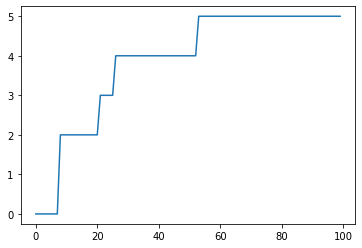

In [121]:
a.plt_SFS1(1, np.array([0.5,0.5]))

In [ ]:
a.run()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.74it/s]


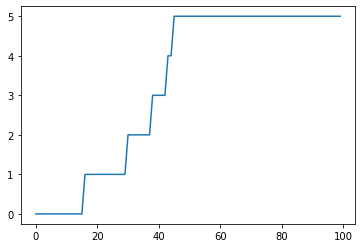

In [23]:
a.plt_SFS1(np.array([0.5,0.5]))

<module 'numpy.linalg' from '/opt/miniconda3/envs/genomic/lib/python3.10/site-packages/numpy/linalg/__init__.py'>

In [171]:
s = np.array([1, 2, 3.5, 3.000000002])

In [172]:
s

array([1. , 2. , 3.5, 3. ])

In [174]:
s = np.array([1, 2, 3, 3])

In [175]:
s

array([1, 2, 3, 3])